# cygnus-cache

Analyze cache behavior of Cygnus / Best Fixed Offset (BFO).


In [38]:
from importlib import reload

from matplotlib import cm
import pandas as pd

from utils import plots, tables
#%matplotlib widget

In [39]:
# Knobs
paths = {
    'degree1_fixed_offset': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_fixed_offset.csv', # Different fixed offsets (-64 to +63)
    'degree1_featureless_tuned_nozeroaction': '/u/cmolder/GitHub/ChampSim/out/pythia/degree1_featureless_tuned_nozeroaction.csv',
}

suites = [
    ('spec06', 'one_phase'),
    #('spec06', 'weighted'),
    ('gap', 'one_phase')
]
features = [{'Delta_Path', 'PC_Delta'}]
dpi = 150

# Plots (suites)
Fix prefetch degree to 1 for everything.

In [47]:
from importlib import reload
from utils import utils
reload(tables)
reload(utils)
dfs = {
    # Baseline models
    'degree1_fixed_offset': tables.load_stats_csv_next_line(paths['degree1_fixed_offset']),
    'degree1_featureless_tuned_nozeroaction': tables.load_stats_csv(paths['degree1_featureless_tuned_nozeroaction'], ['cygnus'], prefetchers_level='l2'),
}

In [43]:
def get_bfo_offset_choices(dfs):
    """Return the offset that provides the best IPC for each run.
    """
    trace_offset_choices = {}

    for run in dfs['best'].run_name.unique():
        bfo_ipc = dfs['best'][dfs['best'].run_name == run].ipc.max()
        for k, v in dfs.items():
            tr_dfs = v[v.run_name == run]
            k_ipc = tr_dfs.ipc.max()
            if k_ipc == bfo_ipc and k != 'best':
                trace_offset_choices[run] = k
    return trace_offset_choices

def get_cygnus_offset_choices(dfs):
    """Return the offset with the largest Q-value for Cygnus for each run.
    """
    trace_qv_offsets = {}
    trace_chosen_offsets = {}
    trace_str_offsets = {}
    for run in dfs['cygnus'].run_name.unique():
        path = dfs['cygnus'][dfs['cygnus'].run_name == run].path.iloc[0]
        
        with open(path) as f:
            qvs, chosen = {}, {}
            for line in f:
                if 'Q: ' in line:
                    key = line.split()[0]
                    qvs[key] = float(line.split()[2])
                    chosen[key] = int(line.split()[5])
   
        trace_qv_offsets[run] = max(zip(qvs.values(), qvs.keys()))[1]
        trace_chosen_offsets[run] = max(zip(chosen.values(), chosen.keys()))[1]
        trace_str_offsets[run] = f'{trace_qv_offsets[run]}/{trace_chosen_offsets[run]}'

    return trace_str_offsets

In [48]:
offset_annotations = {
    'Cygnus L2': get_cygnus_offset_choices(dfs['degree1_featureless_tuned_nozeroaction']),
    'BFO L2': get_bfo_offset_choices(dfs['degree1_fixed_offset']),
}

## L2/L3 hit ratios

In [49]:
def get_llc_hrs(df):
    return df.rename(columns={'LLC_hit_ratio': 'hit_ratio'})

def get_l2_hrs(df):
    return df.rename(columns={'L2C_hit_ratio': 'hit_ratio'})

=== spec06 one_phase ===


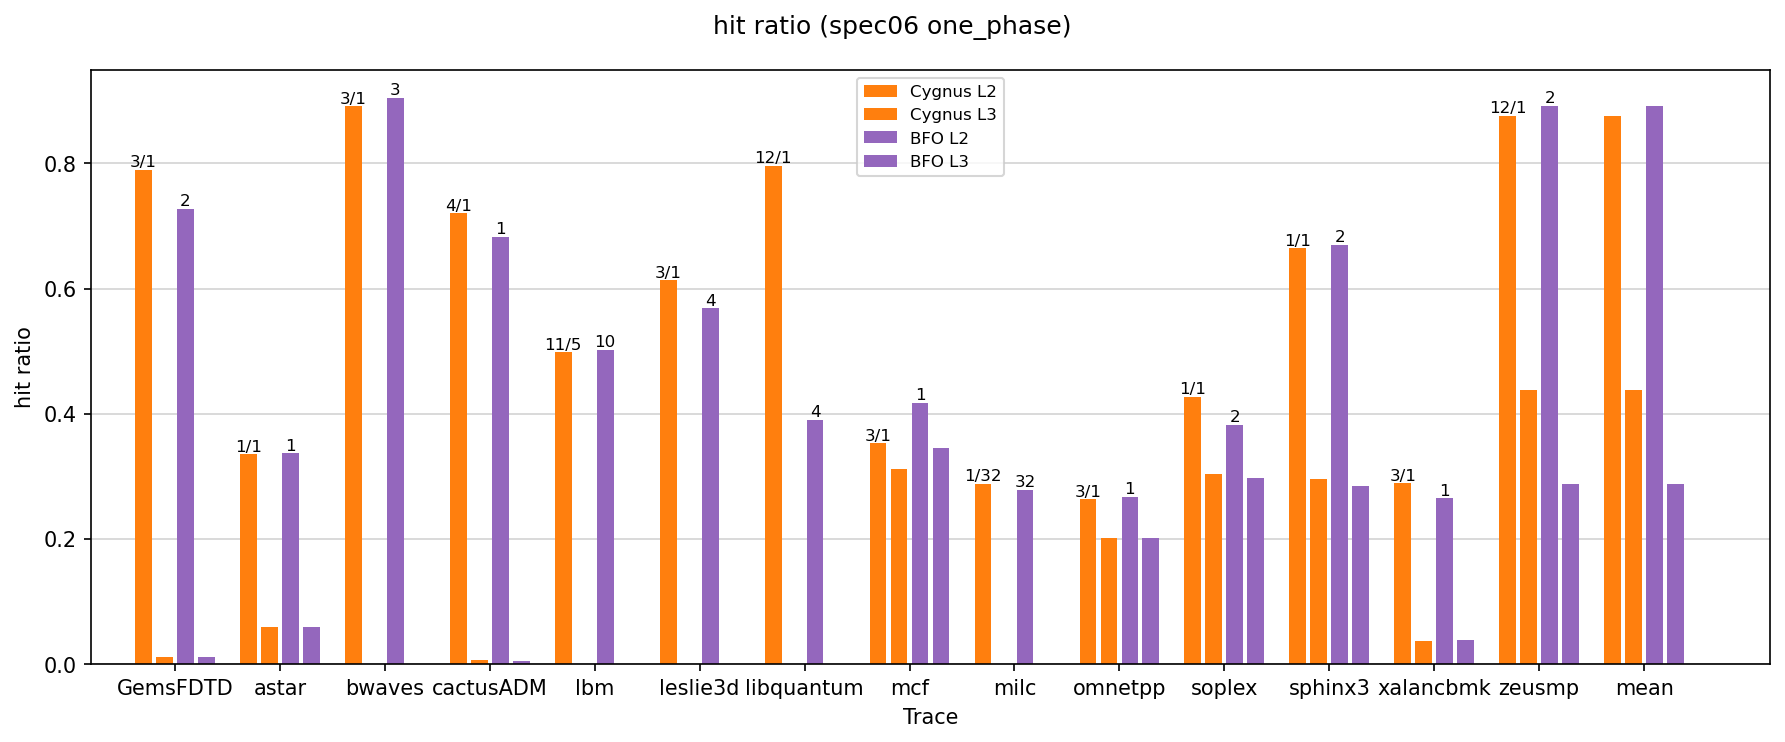

=== gap one_phase ===


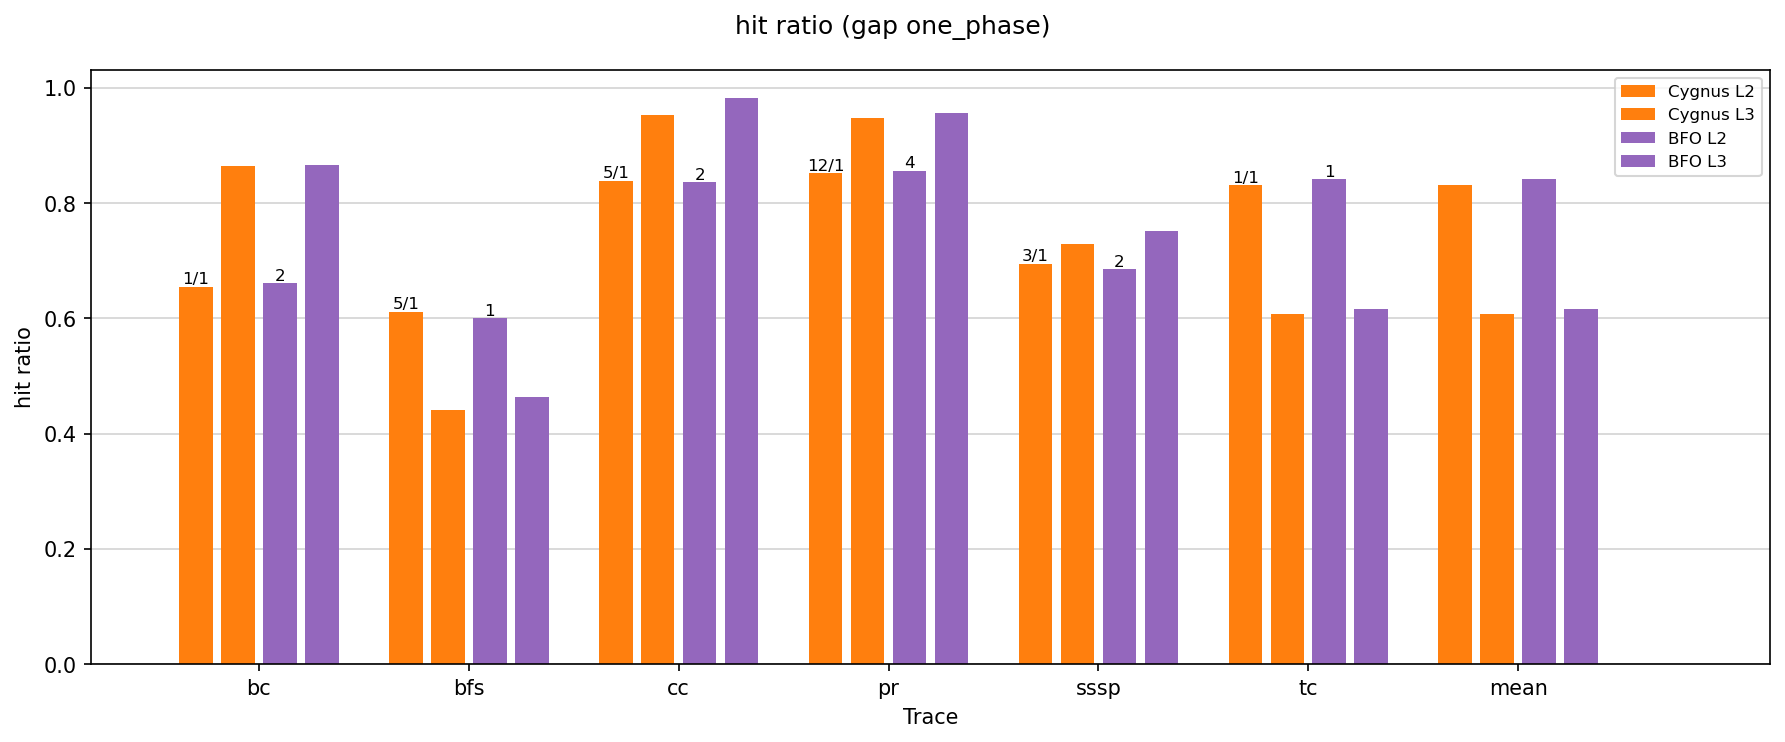

In [50]:
hit_ratio_df = {
    'Cygnus L2': get_l2_hrs(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'Cygnus L3': get_llc_hrs(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'BFO L2': get_l2_hrs(dfs['degree1_fixed_offset']['best']),
    'BFO L3': get_llc_hrs(dfs['degree1_fixed_offset']['best']),
}
hit_ratio_colors = {
    'Cygnus L2': 'C1',
    'Cygnus L3': 'C1',
    'BFO L2': 'C4',
    'BFO L3': 'C4',
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 1,
    #'loc': 'upper left',
    #'bbox_to_anchor': (0, 1),
}
plots.plot_everything(hit_ratio_df, suites=suites, metrics=['hit_ratio'],
                      legend_kwargs=legend_kwargs, dpi=dpi, colors=hit_ratio_colors,
                      annotations=offset_annotations, figsize=(12,5))

## L2/L3 avg. miss latencies

In [51]:
def get_llc_avg_miss_latencies(df):
    return df.rename(columns={'LLC_avg_miss_latency': 'avg_miss_latency'})

def get_l2_avg_miss_latencies(df):
    return df.rename(columns={'L2C_avg_miss_latency': 'avg_miss_latency'})

=== spec06 one_phase ===


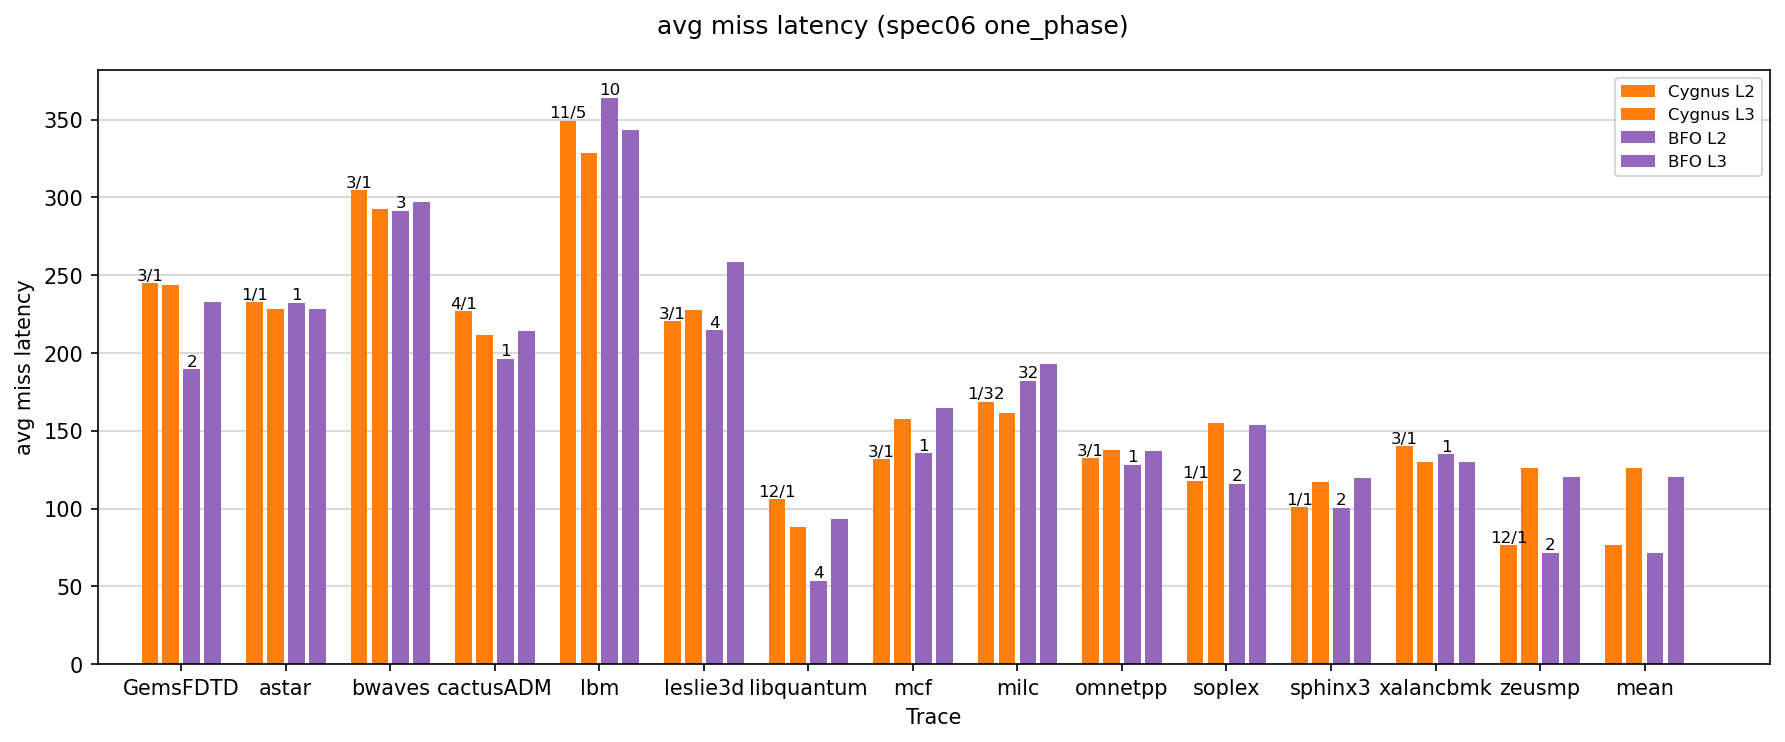

=== gap one_phase ===


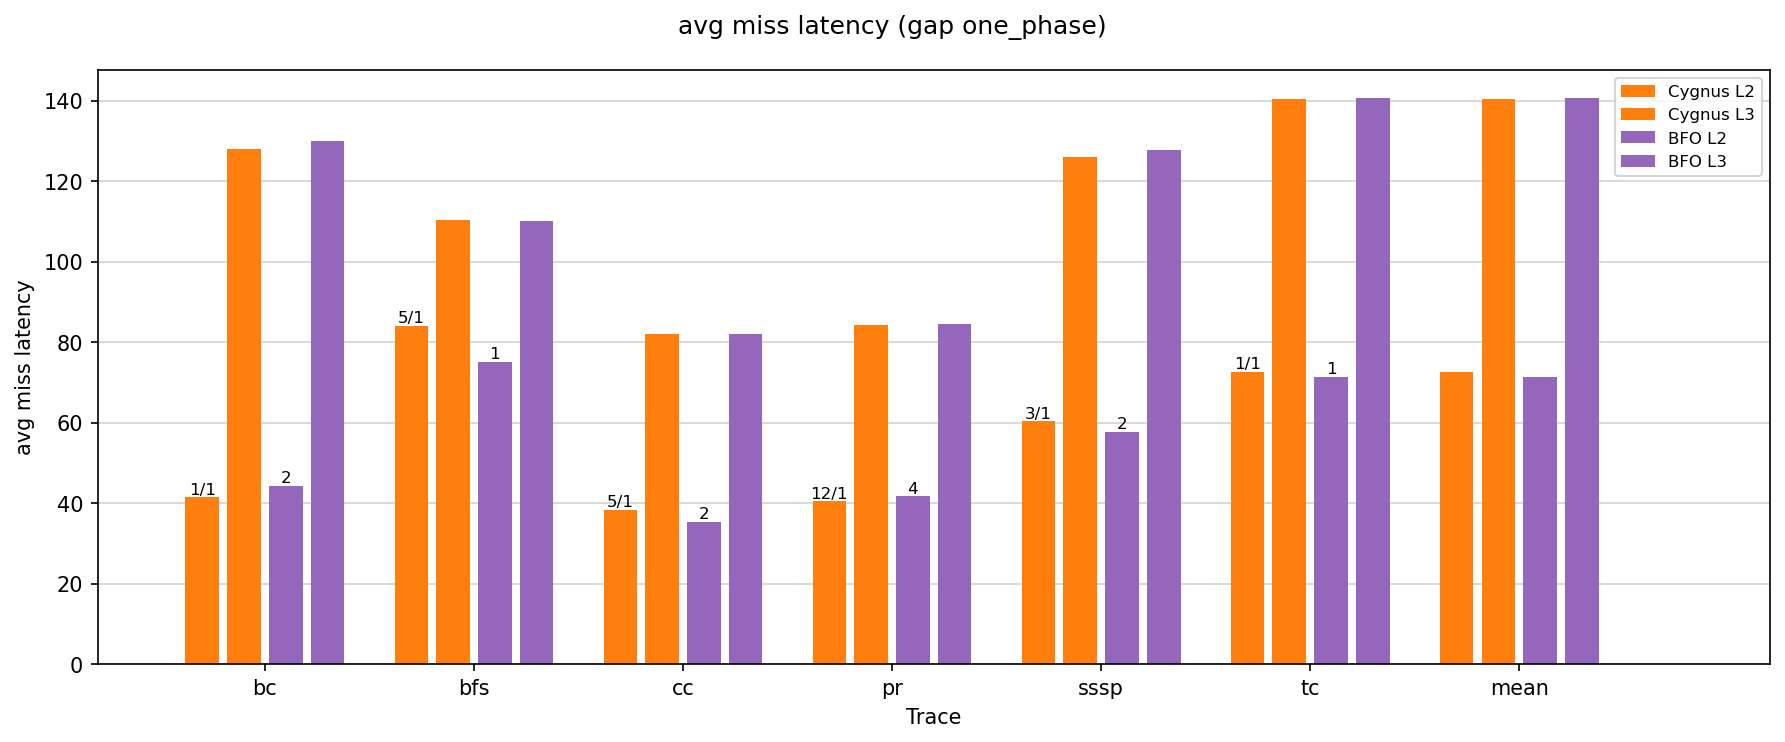

In [52]:
reload(plots)
avg_miss_latencies_df = {
    'Cygnus L2': get_l2_avg_miss_latencies(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'Cygnus L3': get_llc_avg_miss_latencies(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'BFO L2': get_l2_avg_miss_latencies(dfs['degree1_fixed_offset']['best']),
    'BFO L3': get_llc_avg_miss_latencies(dfs['degree1_fixed_offset']['best']),
}
avg_miss_latencies_colors = {
    'Cygnus L2': 'C1',
    'Cygnus L3': 'C1',
    'BFO L2': 'C4',
    'BFO L3': 'C4',
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 1,
    #'loc': 'upper left',
    #'bbox_to_anchor': (0, 1),
}
plots.plot_everything(avg_miss_latencies_df, suites=suites, metrics=['avg_miss_latency'],
                      legend_kwargs=legend_kwargs, dpi=dpi, colors=avg_miss_latencies_colors,
                      annotations=offset_annotations, figsize=(12,5))

## L2/L3 avg. access latencies

$\text{Avg access latency} = (\text{hit ratio} * \text{avg hit latency}) + ((1 - \text{hit ratio}) * \text{avg miss latency})$

In [53]:
def get_llc_avg_access_latencies(df):
    return df.rename(columns={'LLC_avg_access_latency': 'avg_access_latency'})

def get_l2_avg_access_latencies(df):
    return df.rename(columns={'L2C_avg_access_latency': 'avg_access_latency'})

=== spec06 one_phase ===


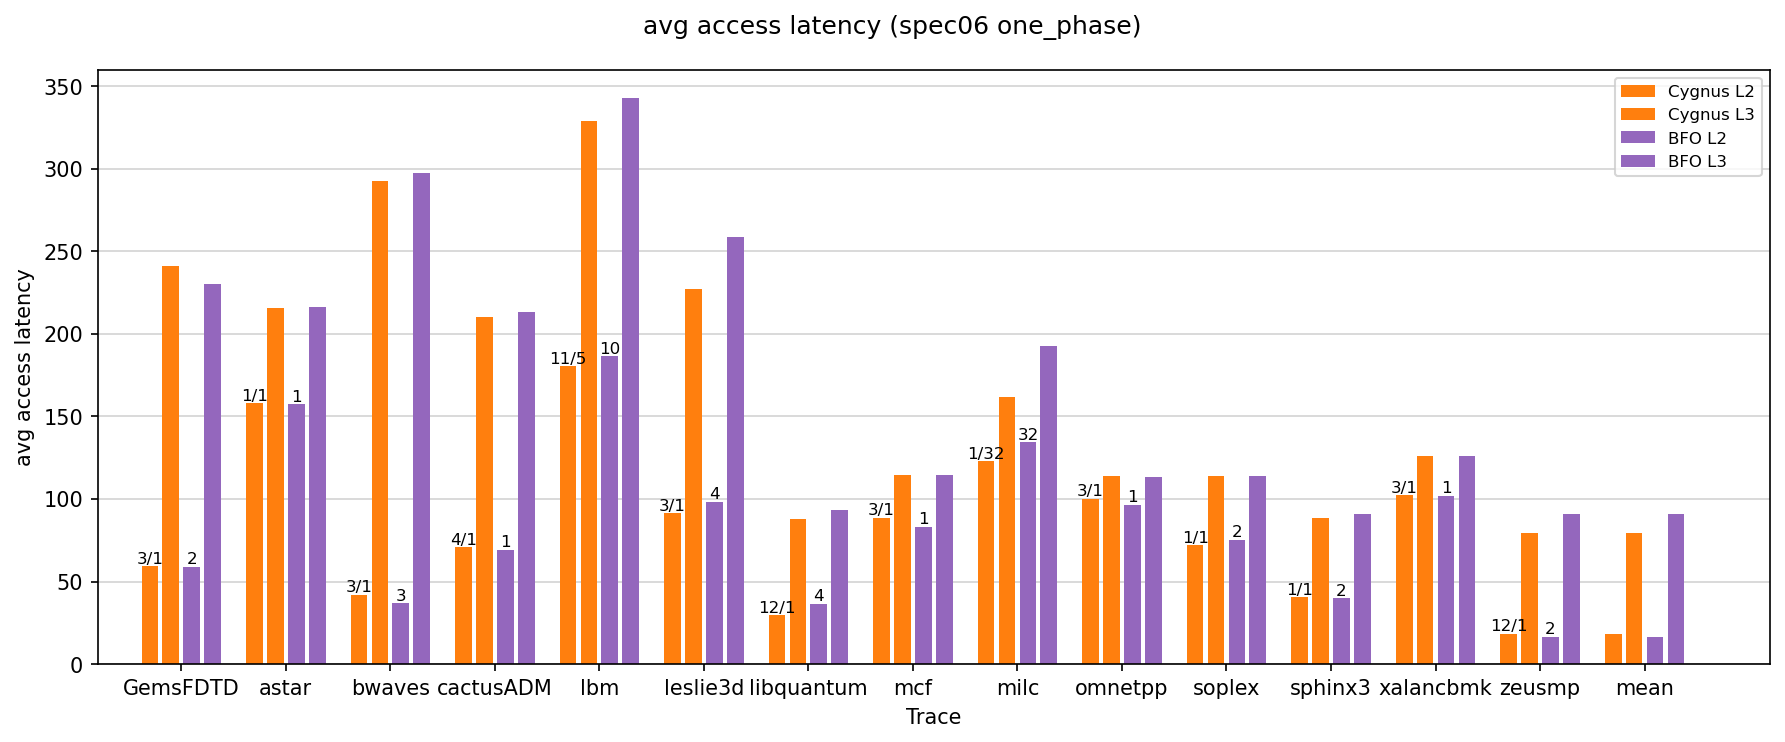

=== gap one_phase ===


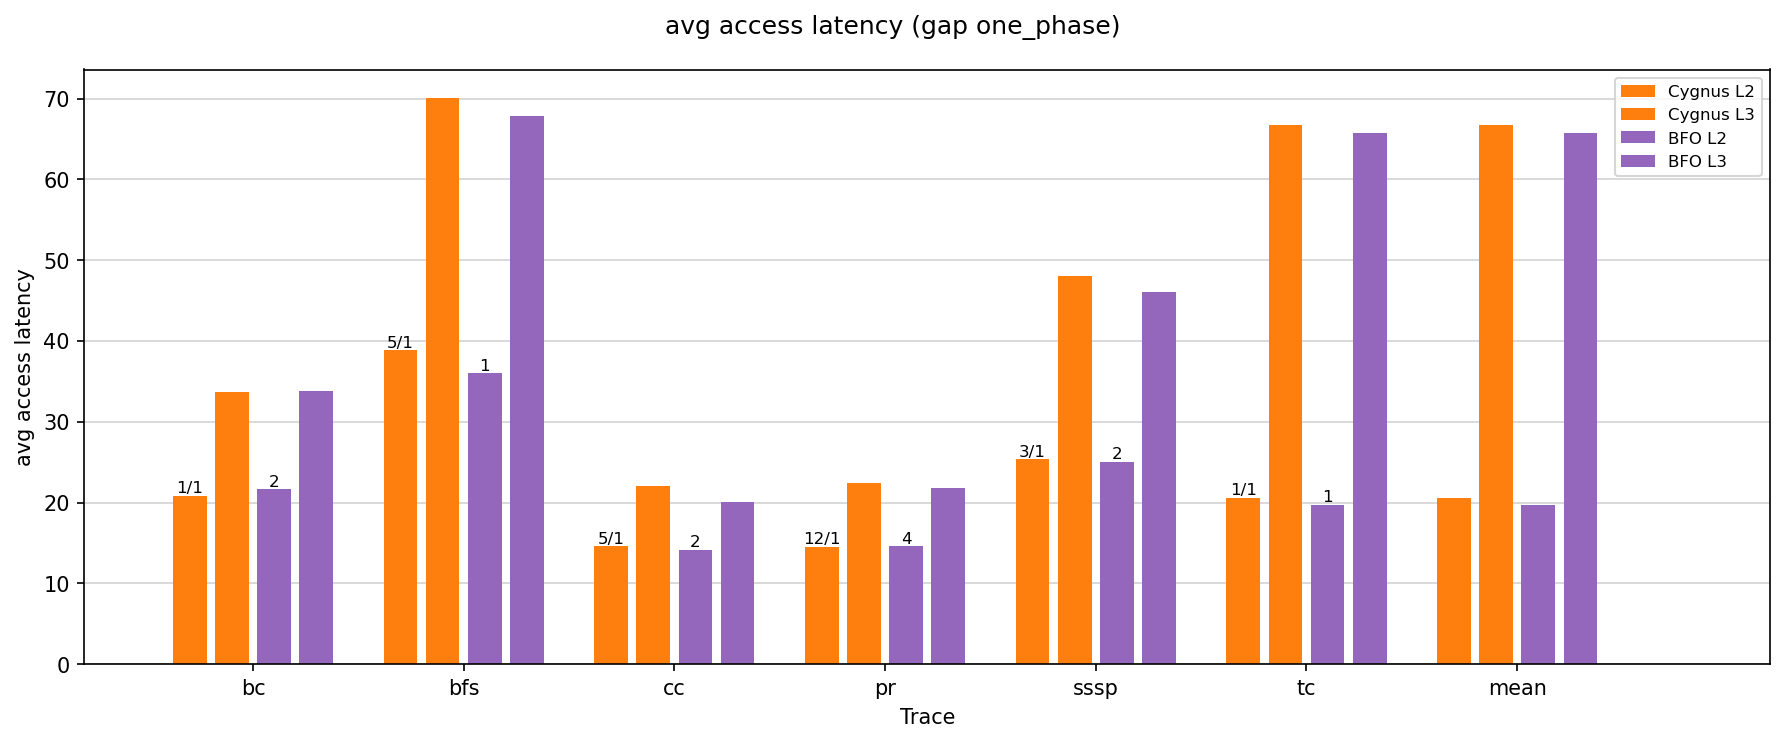

In [54]:
reload(plots)
avg_access_latencies_df = {
    'Cygnus L2': get_l2_avg_access_latencies(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'Cygnus L3': get_llc_avg_access_latencies(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'BFO L2': get_l2_avg_access_latencies(dfs['degree1_fixed_offset']['best']),
    'BFO L3': get_llc_avg_access_latencies(dfs['degree1_fixed_offset']['best']),
}
avg_access_latencies_colors = {
    'Cygnus L2': 'C1',
    'Cygnus L3': 'C1',
    'BFO L2': 'C4',
    'BFO L3': 'C4',
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 1,
    #'loc': 'upper left',
    #'bbox_to_anchor': (0, 1),
}
plots.plot_everything(avg_access_latencies_df, suites=suites, metrics=['avg_access_latency'],
                      legend_kwargs=legend_kwargs, dpi=dpi, colors=avg_access_latencies_colors,
                      annotations=offset_annotations, figsize=(12,5))

## L2/L3 coverage

In [59]:
def get_llc_avg_access_latencies(df):
    print('LLC_coverage')
    llc_coverages = df['LLC_coverage']
    df['coverage'] = llc_coverages.copy()
    return df.copy()

def get_l2_avg_access_latencies(df):
    print('L2C_coverage')
    l2c_coverages = df['L2C_coverage']
    df['coverage'] = l2c_coverages.copy()
    return df.copy()

L2C_coverage
LLC_coverage
L2C_coverage
LLC_coverage
=== spec06 one_phase ===


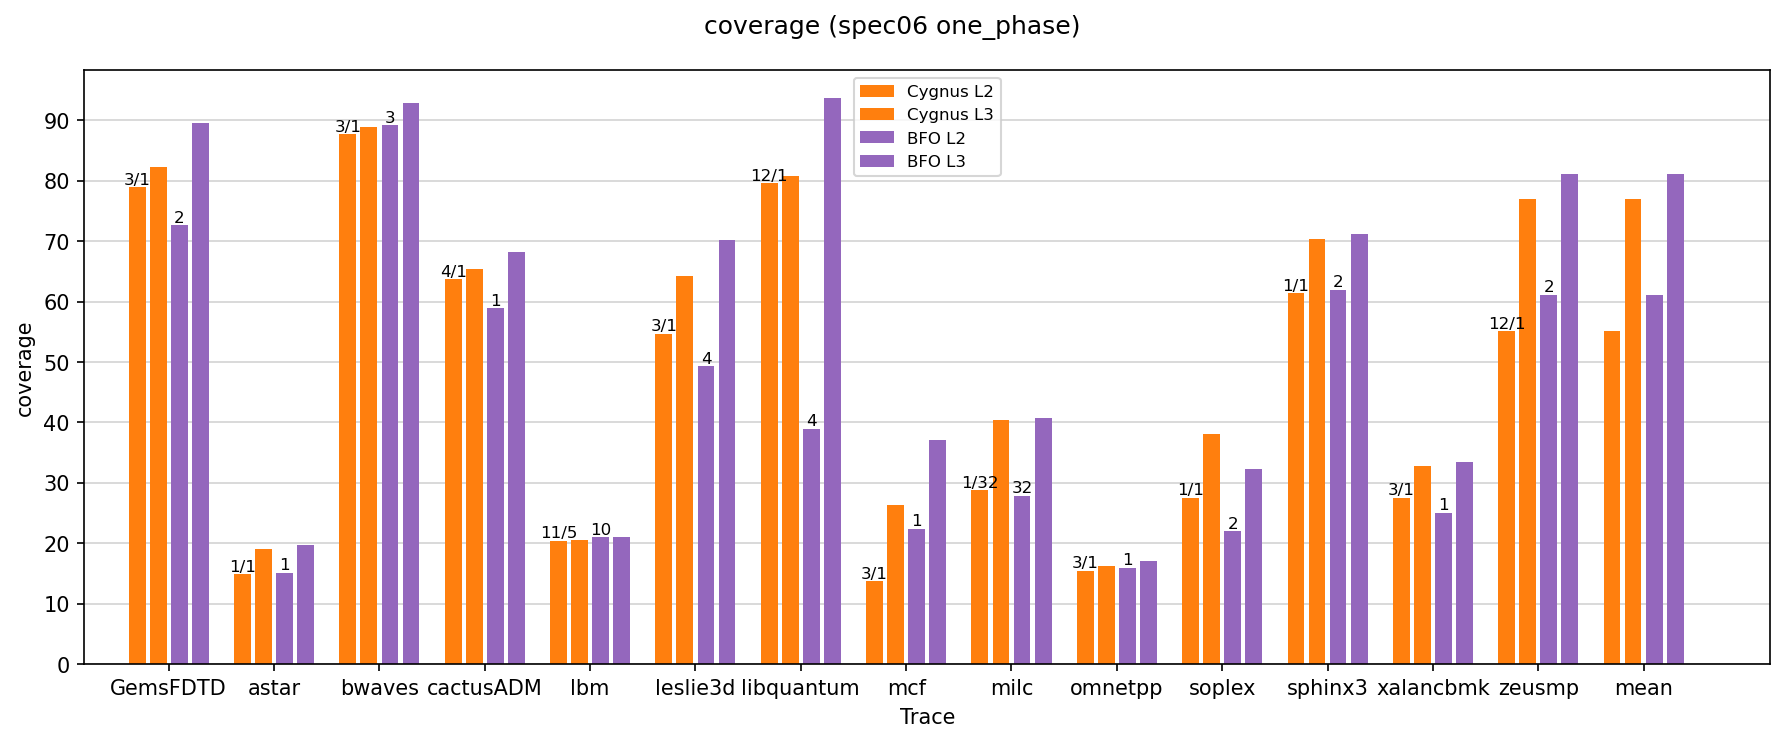

=== gap one_phase ===


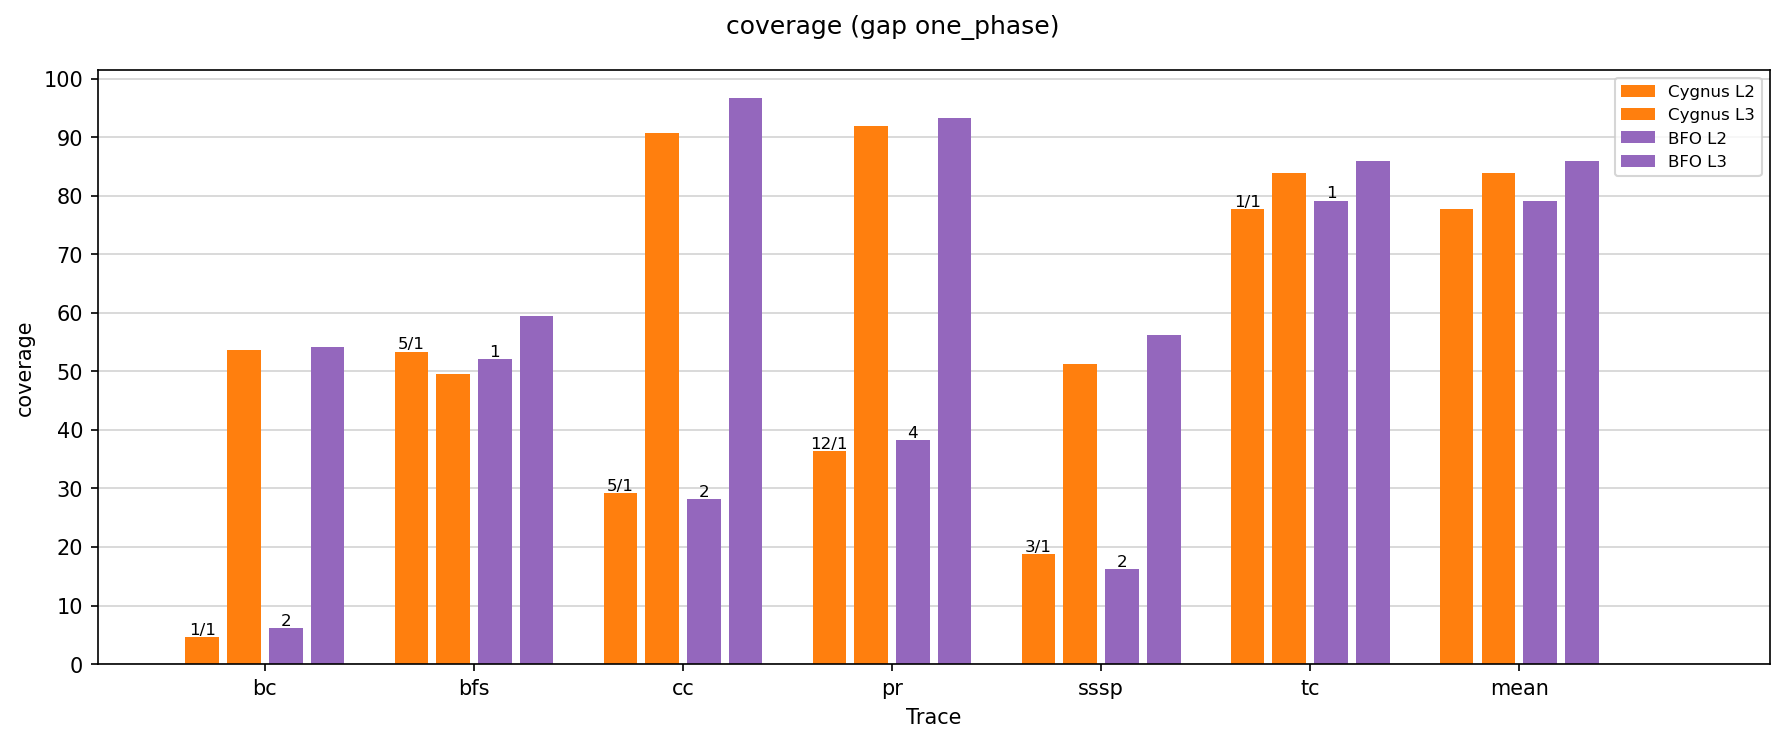

In [60]:
reload(plots)
coverages_df = {
    'Cygnus L2': get_l2_avg_access_latencies(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'Cygnus L3': get_llc_avg_access_latencies(dfs['degree1_featureless_tuned_nozeroaction']['cygnus']),
    'BFO L2': get_l2_avg_access_latencies(dfs['degree1_fixed_offset']['best']),
    'BFO L3': get_llc_avg_access_latencies(dfs['degree1_fixed_offset']['best'])
}
coverages_colors = {
    'Cygnus L2': 'C1',
    'Cygnus L3': 'C1',
    'BFO L2': 'C4',
    'BFO L3': 'C4',
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 1,
    #'loc': 'upper left',
    #'bbox_to_anchor': (0, 1),
}
plots.plot_everything(coverages_df, suites=suites, metrics=['coverage'],
                      legend_kwargs=legend_kwargs, dpi=dpi, colors=coverages_colors,
                      annotations=offset_annotations, figsize=(12,5))

## Average memory access time (AMAT)

In [ ]:
reload(plots)
amat_df = {
    'Cygnus': dfs['degree1_featureless_tuned_nozeroaction']['cygnus'],
    'BFO': dfs['degree1_fixed_offset']['best'],
}
amat_colors = {
    'Cygnus': 'C1',
    'BFO': 'C4',
}
amat_offset_annotations = {
    'Cygnus': offset_annotations['Cygnus L2'],
    'BFO': offset_annotations['BFO L2']
}
legend_kwargs = {
    'fontsize': 8,
    'ncol': 1,
    #'loc': 'upper left',
    #'bbox_to_anchor': (0, 1),
}
plots.plot_everything(amat_df, suites=suites, metrics=['amat'],
                      legend_kwargs=legend_kwargs, dpi=dpi, colors=amat_colors,
                      annotations=amat_offset_annotations, figsize=(12,5))

# Tables

## L2/L3 hit ratios

In [37]:
tables.table_everything(coverages_df, metrics=['coverage'])

=== spec06 one_phase ===
coverage


,Cygnus L2,Cygnus L3,BFO L2,BFO L3
run_name,,,,
GemsFDTD_109B,82.232408,82.232408,89.649992,89.649992
astar_313B,19.086288,19.086288,19.664701,19.664701
bwaves_1861B,88.873819,88.873819,92.863938,92.863938
cactusADM_734B,65.454732,65.454732,68.199827,68.199827
lbm_94B,20.548119,20.548119,21.097698,21.097698
leslie3d_1116B,64.169113,64.169113,70.182149,70.182149
leslie3d_94B,77.556578,77.556578,77.105889,77.105889
libquantum_1210B,80.868597,80.868597,93.747950,93.747950
mcf_46B,26.341289,26.341289,37.111716,37.111716
